In [ ]:
import sys  
!{sys.executable} -m pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import unicodedata
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer , TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf 
import keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
#from keras.layers.embeddings import Embedding
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load CSV files into Colab:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get rid of the unnamed column:

path ="/content/drive/Shareddrives/CS675 Project/data/WELFake_Dataset.csv"

df = pd.read_csv(path, index_col=0)

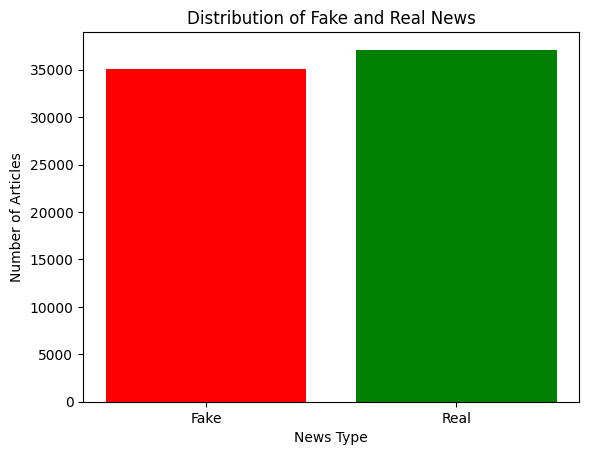

In [ ]:
# Distribution of Fake and Real News 

grouped_data = df.groupby('label').size()
plt.bar(grouped_data.index, grouped_data.values, color=['red', 'green'])
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel('News Type')
plt.ylabel('Number of Articles')
plt.title('Distribution of Fake and Real News')
plt.show()

In [ ]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
# remove null values

df.dropna(inplace=True)
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
y = df.label
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

Ratio of real and fake news:


real    0.510351
fake    0.489649
Name: label, dtype: float64

In [ ]:
# Analysis on text length
# we are interested to know that whether the length is a discriminatory feature/factor between fake and real news category.

df["body_len"] = df["text"].apply(lambda x: len(x) - x.count(" ")) # remove space
df.head()

,title,text,label,body_len
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert following threats c...,1,2759
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general says char...,1,234
3,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu uses story christian...,0,4866
4,SATAN 2: Russia unvelis an image of its terrif...,satan russia unvelis image terrifying new supe...,1,1211
5,About Time! Christian Group Sues Amazon and SP...,time christian group sues amazon splc designat...,1,995


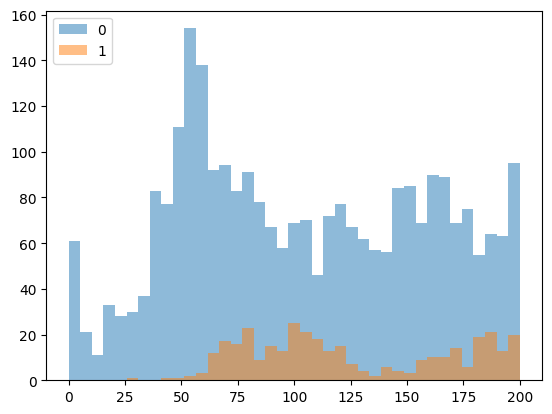

In [ ]:
bins = np.linspace(0, 200, 40)
plt.hist(df[df["label"]== 1]["body_len"], bins, alpha=0.5, label=0)
plt.hist(df[df["label"]== 0]["body_len"], bins, alpha=0.5, label=1)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Combining Title and Text data into one feature:

df['text'] = df['title'] + ' ' + df['text']

In [ ]:
display(df['text'][0])

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:3

In [ ]:
# Remove URL's from text:

def remove_URL(text):
    text = re.sub(r"http\S+", "", text)
    # text = re.sub(r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    return text


df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [ ]:
# Remove non-ASCII characters from text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


df['text'] = df['text'].apply(lambda x : remove_accented_chars(x))

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [ ]:
def clean_text(text):
   
    text = re.sub('\[.*?\]', '', text)  # remove text in square brackets
    text = re.sub('<.*?>+', '', text)  # remove html tags
    text = re.sub('\n', ' ', text)
    text = re.sub('[‘’“”…]', '', text)  # remove those fancy quotes
    text = text.lower()
    return text


df['text'] = df['text'].apply(lambda x : clean_text(x))

In [ ]:
# Replace CONTRACTIONS

df['text']  = df['text'].apply(lambda x : contractions.fix(x))

print(contractions.fix("you've"))
print(contractions.fix("he's"))

you have
he is


In [ ]:
# Remove punctuation and numbers
def remove_punctuation_number(text, remove_digits=False):
    text = re.sub(r'[%s]' % re.escape(''.join(string.punctuation)), r' ', text)  # remove punctuation
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


df['text'] = df['text'].apply(lambda x : remove_punctuation_number(x, True))

remove_punctuation_number("Well this was fun! What do you think? 123#@!", remove_digits=True)

'Well this was fun  What do you think     '

In [ ]:
# REMOVE STOPWORDS

nltk.download('wordnet')
nltk.download('stopwords')
stoplist = set(stopwords.words('english'))

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
display(df['text'][0])

'law enforcement high alert following threats cops whites blacklivesmatter fyf terrorists comment expected barack obama members fyf fukyoflag blacklivesmatter movements called lynching hanging white people cops encouraged others radio show tuesday night turn tide kill white people cops send message killing black people america one f yoflag organizers called sunshine radio blog show hosted texas called sunshine f ing opinion radio show snapshot fyf lolatwhitefear twitter page p shows urging supporters call fyf tonight continue dismantle illusion white snapshot twitter radio call invite fyfthe radio show aired p eastern standard time show callers clearly call lynching killing white people minute clip radio show heard provided breitbart texas someone would like referred hannibal already received death threats result interrupting fyf conference calls unidentified black man said mother f kers start f ing like us bunch ni ers takin one us roll said already roll gangs anyway six seven black m

In [ ]:
### 

In [ ]:
# TOKENIZE DATA
from nltk.tokenize import word_tokenize

df['text'] = df['text'].apply(lambda x:word_tokenize(x))

In [ ]:
display(df['text'][0])

['law',
 'enforcement',
 'high',
 'alert',
 'following',
 'threats',
 'cops',
 'whites',
 'blacklivesmatter',
 'fyf',
 'terrorists',
 'comment',
 'expected',
 'barack',
 'obama',
 'members',
 'fyf',
 'fukyoflag',
 'blacklivesmatter',
 'movements',
 'called',
 'lynching',
 'hanging',
 'white',
 'people',
 'cops',
 'encouraged',
 'others',
 'radio',
 'show',
 'tuesday',
 'night',
 'turn',
 'tide',
 'kill',
 'white',
 'people',
 'cops',
 'send',
 'message',
 'killing',
 'black',
 'people',
 'america',
 'one',
 'f',
 'yoflag',
 'organizers',
 'called',
 'sunshine',
 'radio',
 'blog',
 'show',
 'hosted',
 'texas',
 'called',
 'sunshine',
 'f',
 'ing',
 'opinion',
 'radio',
 'show',
 'snapshot',
 'fyf',
 'lolatwhitefear',
 'twitter',
 'page',
 'p',
 'shows',
 'urging',
 'supporters',
 'call',
 'fyf',
 'tonight',
 'continue',
 'dismantle',
 'illusion',
 'white',
 'snapshot',
 'twitter',
 'radio',
 'call',
 'invite',
 'fyfthe',
 'radio',
 'show',
 'aired',
 'p',
 'eastern',
 'standard',
 'time

In [ ]:
# LEMMATIZE DATA
def lemmatizer(text):
    lem_text = ' '.join(WordNetLemmatizer().lemmatize(i) for i in text)
    return lem_text


df['text'] = df['text'].apply(lambda x: lemmatizer(x))

In [ ]:
display(df['text'][0])

'law enforcement high alert following threat cop white blacklivesmatter fyf terrorist comment expected barack obama member fyf fukyoflag blacklivesmatter movement called lynching hanging white people cop encouraged others radio show tuesday night turn tide kill white people cop send message killing black people america one f yoflag organizer called sunshine radio blog show hosted texas called sunshine f ing opinion radio show snapshot fyf lolatwhitefear twitter page p show urging supporter call fyf tonight continue dismantle illusion white snapshot twitter radio call invite fyfthe radio show aired p eastern standard time show caller clearly call lynching killing white people minute clip radio show heard provided breitbart texas someone would like referred hannibal already received death threat result interrupting fyf conference call unidentified black man said mother f kers start f ing like u bunch ni er takin one u roll said already roll gang anyway six seven black mother f ckers see 

In [ ]:
# Split the dataset into training and test sets
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
# VECTORIZE DATA

# Bag of Words
count_vectorizer = CountVectorizer()
train_vectors_count = count_vectorizer.fit_transform(X_train)
test_vectors_count = count_vectorizer.transform(X_test)

In [ ]:
# VECTORIZE DATA

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

# **MODELING**

In [ ]:
#  Logistic Regression

lr = LogisticRegression(C=100, random_state=11, solver='lbfgs', multi_class='ovr', penalty='l2', max_iter=1000)
lr.fit(train_vectors_count, y_train)
print(lr.score(train_vectors_count, y_train))

lr_pred = lr.predict(test_vectors_count)
# print(lr.score(test_vectors_count, y_test))
print(classification_report(y_test, lr_pred))

1.0
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7006
           1       0.95      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [ ]:
#  Naive Bayes

nb_classifier = MultinomialNB()
nb_classifier.fit(train_vectors_count, y_train)
nb_pred = nb_classifier.predict(test_vectors_count)
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7006
           1       0.89      0.90      0.89      7302

    accuracy                           0.89     14308
   macro avg       0.89      0.89      0.89     14308
weighted avg       0.89      0.89      0.89     14308



In [ ]:
# Random Forest with BoW

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_vectors_count, y_train)
rf_pred = rf.predict(test_vectors_count)
print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7006
           1       0.94      0.95      0.94      7302

    accuracy                           0.94     14308
   macro avg       0.94      0.94      0.94     14308
weighted avg       0.94      0.94      0.94     14308



In [ ]:
# Random Forest with TF_IDF

rf.fit(tfidf_train_vectors, y_train)
rf_pred2 = rf.predict(tfidf_test_vectors)
print(classification_report(y_test, rf_pred2))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7006
           1       0.93      0.95      0.94      7302

    accuracy                           0.94     14308
   macro avg       0.94      0.94      0.94     14308
weighted avg       0.94      0.94      0.94     14308



# **RNN starting here**

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

177995


In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Apply padding so we have the same length for each article

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=512)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=512)

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1717/1717 [==============================] - 306s 173ms/step - loss: 0.2578 - accuracy: 0.8785 - val_loss: 0.1234 - val_accuracy: 0.9530
Epoch 2/10
1717/1717 [==============================] - 148s 86ms/step - loss: 0.1045 - accuracy: 0.9660 - val_loss: 0.1097 - val_accuracy: 0.9640
Epoch 3/10
1717/1717 [==============================] - 122s 71ms/step - loss: 0.0701 - accuracy: 0.9791 - val_loss: 0.1234 - val_accuracy: 0.9568
Epoch 4/10
1717/1717 [==============================] - 113s 66ms/step - loss: 0.0485 - accuracy: 0.9868 - val_loss: 0.1126 - val_accuracy: 0.9651


In [ ]:
test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
y_hat1 = model1.predict(X_test)

print('Test Loss:', test_loss1)
print('Test Accuracy:', test_acc1)

448/448 [==============================] - 13s 25ms/step
Test Loss: 0.11904348433017731
Test Accuracy: 0.9601621627807617


In [ ]:
## print classification report for RNN - LSTM
print(classification_report(y_test, np.where(y_hat1 >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7006
           1       0.95      0.97      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



In [ ]:
# RNN Model with Different Hyperparameters:

In [ ]:
MAX_LEN = 512
model2 = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tokenizer.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 128)          22783360  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
history = model2.fit(X_train, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
716/716 [==============================] - 176s 228ms/step - loss: 0.2790 - accuracy: 0.8781 - val_loss: 0.1681 - val_accuracy: 0.9354
Epoch 2/10
716/716 [==============================] - 107s 149ms/step - loss: 0.1224 - accuracy: 0.9582 - val_loss: 0.1332 - val_accuracy: 0.9540
Epoch 3/10
716/716 [==============================] - 94s 132ms/step - loss: 0.0792 - accuracy: 0.9751 - val_loss: 0.1292 - val_accuracy: 0.9548
Epoch 4/10
716/716 [==============================] - 84s 117ms/step - loss: 0.0522 - accuracy: 0.9851 - val_loss: 0.1195 - val_accuracy: 0.9635
Epoch 5/10
716/716 [==============================] - 79s 111ms/step - loss: 0.0318 - accuracy: 0.9912 - val_loss: 0.1294 - val_accuracy: 0.9641
Epoch 6/10
716/716 [==============================] - 75s 105ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.1875 - val_accuracy: 0.9444
Epoch 7/10
716/716 [==============================] - 73s 102ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.1779 - val_

In [ ]:
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
y_hat2 = model2.predict(X_test)

print('Test Loss:', test_loss2)
print('Test Accuracy:', test_acc2)

448/448 [==============================] - 13s 27ms/step
Test Loss: 0.12566840648651123
Test Accuracy: 0.9642857313156128


In [ ]:
## print classification report for RNN - LSTM
print(classification_report(y_test, np.where(y_hat2 >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7006
           1       0.96      0.97      0.97      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



Text(70.72222222222221, 0.5, 'True Labels')

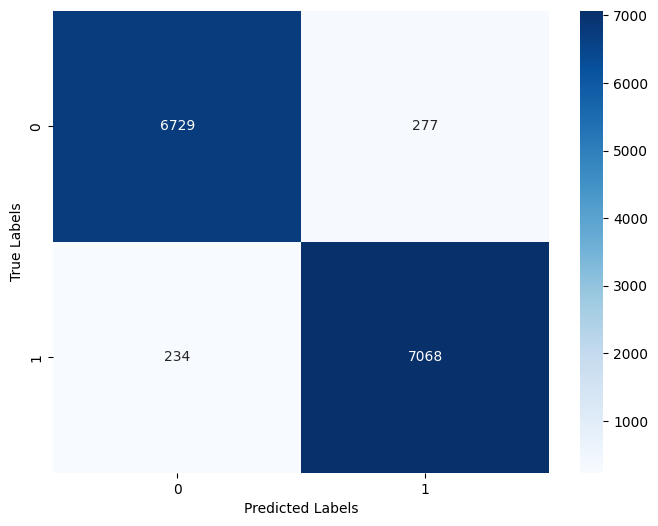

In [ ]:
import seaborn as sns
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat2 >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# **RNN + CNN**

References:

https://towardsdatascience.com/how-to-build-a-recurrent-neural-network-to-detect-fake-news-35953c19cf0b

https://github.com/matdekoning/FakeNewsClassifier/blob/master/FakeNewsClassifier.ipynb


In [ ]:

# Build the architecture of the model
     
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

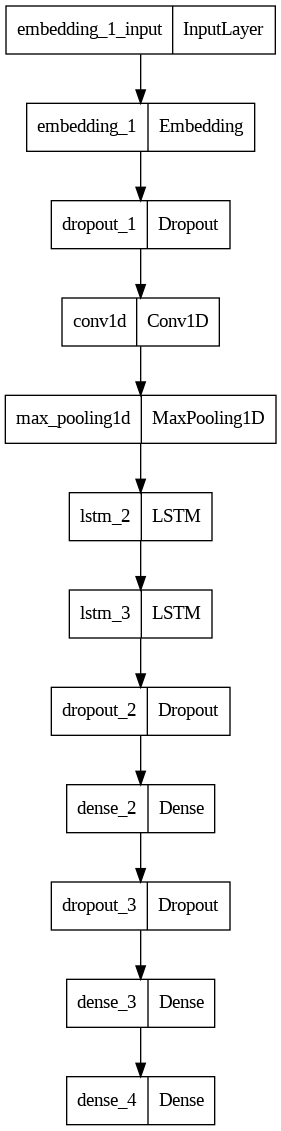

In [ ]:
#plot the model architecture
tf.keras.utils.plot_model(model3)

In [ ]:

model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

history = model3.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=[X_test, y_test])

print("Training Complete")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         22783488  
                                                                 
 dropout_11 (Dropout)        (None, None, 128)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          41024     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_14 (LSTM)              (None, None, 20)          6800      
                                                                 
 lstm_15 (LSTM)              (None, 20)                3280      
                                                      

In [ ]:
test_loss3, test_acc3 = model3.evaluate(X_test, y_test)
y_hat3 = model3.predict(X_test)

print('Test Loss:', test_loss3)
print('Test Accuracy:', test_acc3)

448/448 [==============================] - 5s 8ms/step
Test Loss: 0.18330946564674377
Test Accuracy: 0.9721134901046753


In [ ]:
## print classification report for RNN - LSTM
print(classification_report(y_test, np.where(y_hat3 >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7006
           1       0.96      0.99      0.97      7302

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



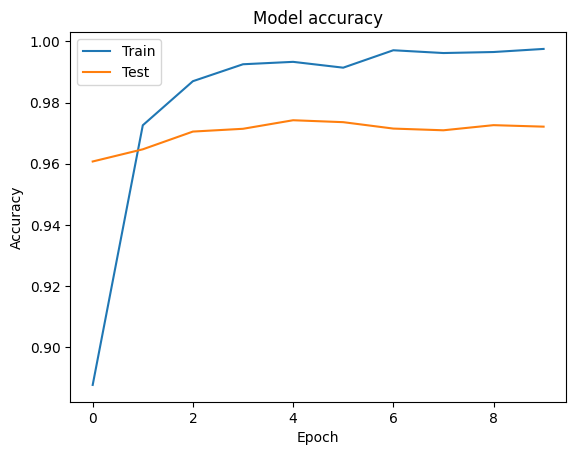

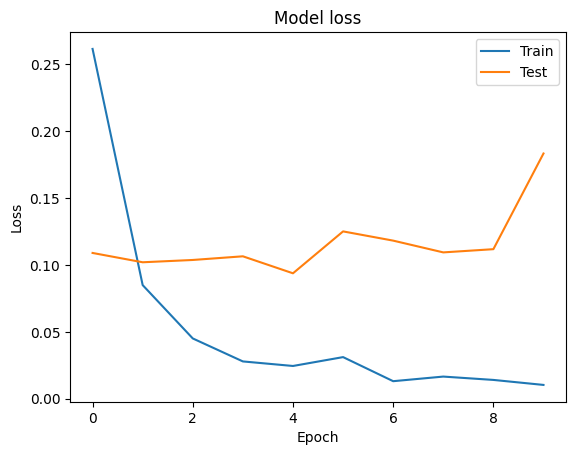

In [ ]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()